In [1]:
import math 
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BOLTZMANN = 1.380649e-23 
AVOGADRO = 6.02214076e23
KILO = 1e3
RGAS = BOLTZMANN*AVOGADRO
BOLTZ = (RGAS/KILO)  

In [3]:
d = 1
n = 10
Reduced_Temp = 1
Multiplier = 119.8
T = Reduced_Temp * Multiplier

## MD simulation functions

In [4]:
def generate_velocities(number_particles, system_dimension, masses, temperature):
    h = []
    dof = number_particles * system_dimension
    while(len(h) < dof):
        r2 = 0
        while r2 >= 1 or r2 == 0:
            x = 2 * random.uniform(0, 1) - 1
            y = 2 * random.uniform(0, 1) - 1
            r2 = x**2 + y**2
        mult = math.sqrt(- 2 * math.log(r2) / r2)
        h.extend([x*mult, y*mult])
    vels = np.array(h[:dof]).reshape(-1, 1).astype('float32')
    scaledvels = vels * np.sqrt(BOLTZ * temperature / masses)
    return scaledvels

In [5]:
def velocity_verlet_step(x, v, m, dt):
    F = np.array(list(map(force, x.flatten()))).reshape(x.shape)
    v = v + (dt / 2) * (F / m)
    x = x + (dt) * v
    F = np.array(list(map(force, x.flatten()))).reshape(x.shape)
    v = v + (dt / 2) * (F / m)
    return x, v

In [228]:
def pot_energy(x):
    if x < -1.25:
        return (4 * (np.pi**2)) * (x + 1.25)**2
    
    if x >= -1.25 and x <= -0.25:
        return 2 * (1 + np.sin(2 * np.pi * x))
        
    if x >= -0.25 and x <= 0.75:
        return 3 * (1 + np.sin(2 * np.pi * x))
                  
    if x >= 0.75 and x <= 1.75:
        return 4 * (1 + np.sin(2 * np.pi * x))
                  
    # if x >= 1.75:
    return 64 * ((x - 7 / 4) ** 2)

In [229]:
def force(x):
    
    if x <= -1.25:
        rv = (-8 * (np.pi)**2) * (x + 1.25)
    
    if x > -1.25 and x <= -0.25:
        rv = -4 * np.pi * np.cos(2 * np.pi * x)
        
    if x >= -0.25 and x <= 0.75:
        rv = -6 * np.pi * np.cos(2 * np.pi * x)
                  
    if x >= 0.75 and x <= 1.75:
        rv = -8 * np.pi * np.cos(2 * np.pi * x)
        
    if x >= 1.75:
        rv = -(128) * (x - 1.75)
                  
    return rv

In [230]:
tmp_x = np.linspace(-5, 5, 1000)
U = np.array(list(map(pot_energy, tmp_x)))
f = np.array(list(map(force, tmp_x)))

[9.869604401089358, 4.0, 6.0, 8.0]


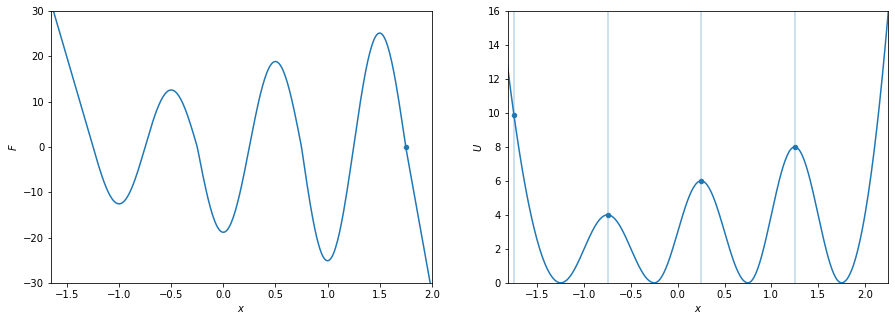

In [231]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

axes[0].plot(tmp_x, f)
axes[0].scatter([1.75], [force(1.75)], s = 20)
axes[0].set_xlabel(r'$x$')
axes[0].set_xlim([-1.65, 2])
axes[0].set_ylim([-30, 30])


_ = axes[0].set_ylabel(r'$F$')

axes[1].plot(tmp_x, U)
axes[1].set_xlabel(r'$x$')
axes[1].set_xlim([-1.815, 2.25])
axes[1].set_ylim([0, 16])
_ = axes[1].set_ylabel(r'$U$')
maximas = [-1.75, -0.75, 0.25, 1.25]
pot = list(map(pot_energy, maximas))
_ = axes[1].scatter(maximas, pot, s = 20)

for i in maximas:
    _ = axes[1].axvline(x = i, alpha = 0.3)

print(pot)


In [196]:
print(-16 * np.pi**2, -128)

-157.91367041742973 -128


## Helper functions

In [11]:
def write_to_file(x, v, step):
    p = ' '.join([str(i) for i in x.flatten()])
    pos_file.write(p)
    pos_file.write("\n")
    
    p = ' '.join([str(i) for i in v.flatten()])
    vel_file.write(p)
    vel_file.write("\n")
    

    
def step(num_steps, x, v, m, dt):
    global vel_file, pos_file
    vel_file = open("velocities.txt", "w")
    pos_file = open("positions.txt", "w")
    for i in range(num_steps):
        x_new, v_new = velocity_verlet_step(x, v, m, dt)
        write_to_file(x, v, i)
        x, v = x_new, v_new
    pos_file.close()
    vel_file.close()

## Andersen Thermostat 

In [45]:
def andersen_step(x, v, dt = 0.001, m = 1, switch = 1, nu = 0.01):
    f = np.array(list(map(force, x.flatten()))).reshape(x.shape)
    
    f = force(x)
    if switch == 1:
        v = v + (dt / 2) * (F / m)
        x = x + (dt) * v
        F = np.array(list(map(force, x.flatten()))).reshape(x.shape)
        v = v + (dt / 2) * (F / m)
    elif switch == 2:
        v = v + dt * (f / (2 * m))
        KE = m * (v ** 2)
        sigma = np.sqrt(reduced_temperature)
        probs = np.random.random(size = (n_p, 1))
        g = np.random.normal(0, sigma, n_p).reshape(-1, 1)
        ind = probs < nu * dt
        if ind.any():
            print("Gaussian velocity replaced")
        v = (probs > nu * dt) * v  + (probs < nu * dt) * g
    return x, v

In [46]:
def write_to_file(x, v, step):
    p = ' '.join([str(i) for i in x.flatten()])
    pos_file.write(p)
    pos_file.write("\n")
    
    p = ' '.join([str(i) for i in v.flatten()])
    vel_file.write(p)
    vel_file.write("\n")
    

    
def step(num_steps, x, v, m, dt, file_path):
    global vel_file, pos_file
    vel_file = open("{}/{}".format(file_path, "velocities.txt"), "w")
    pos_file = open("{}/{}".format(file_path, "positions.txt"), "w")
    for i in range(num_steps):
        x_new, v_new = andersen_step(x, v, m, dt, switch = 2)
        write_to_file(x, v, i)
        x, v = x_new, v_new
    pos_file.close()
    vel_file.close()

In [47]:
config = {
    'num_particles' : 1,
    'temperature' : 0.05,
    'num_steps' : int(1e2),
    'data_files_path' : '/scratch/shaunak/T_0.05'
}

In [48]:
reduced_temperature = config['temperature']
n_p = config['num_particles']
num_steps = config['num_steps']
m = np.ones((n_p, 1))
file_path = config['data_files_path']
print("Number of particles = ", n)
print("Temperature = ", reduced_temperature)

Number of particles =  1
Temperature =  0.05


In [49]:
x = np.random.normal(-1.6, 0.9, size = (n_p, d))
T = reduced_temperature * Multiplier
vel_a = generate_velocities(n, d, m, T)

In [50]:
import os
os.system("mkdir -p {}".format(file_path))

0

In [51]:
num_steps = config['num_steps']
step(num_steps, x, vel_a, m, 1e-3, file_path)